In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination
import matplotlib.pyplot as plt

### Data Loading and Preprocessing

In [2]:
scaler = MinMaxScaler()

In [3]:
def load_and_preprocess_data(df_path, numerical_cols, features):
    # Load datasets
    df = pd.read_csv(df_path)
    
    # Scale numerical features for training data
    scaled_columns = scaler.fit_transform(df[numerical_cols])
    scaled_columns_df = pd.DataFrame(
        scaled_columns, columns=[col + '_scaled' for col in numerical_cols], index=df.index
    )
    df_scaled = pd.concat([df[features], scaled_columns_df], axis=1)

    return df_scaled

In [4]:
# Define paths and features
numerical_cols = ['Thermal Conductivity (W/m*K)', 'Material Density (kg/m3)', 'Weight', 'Durability (d)', 'Cost', 'Thickness']
features = ['Material', 'Material_encoded', 'Thermal Conductivity (W/m*K)']

In [5]:
train_path = 'data/df_expanded_train.csv'
test_path = 'data/df_expanded_test.csv'
ga_path = 'data/df_expanded_ga.csv'

In [6]:
# Load datasets
train_df_scaled = load_and_preprocess_data(train_path, numerical_cols, features)
test_df_scaled = load_and_preprocess_data(test_path, numerical_cols, features)
ga_df_scaled = load_and_preprocess_data(ga_path, numerical_cols, features)

### Surrogate Model Training

In [7]:
def train_surrogate_model(X, y, target_name):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"{target_name} - Cross-Validation R² Scores: {cv_scores}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{target_name} - Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    return model

In [8]:
# Define feature matrix X and target variables y
X = train_df_scaled[['Material_encoded', 
               'Thermal Conductivity (W/m*K)_scaled', 
               'Material Density (kg/m3)_scaled', 
               'Thickness_scaled']]

y_weight = train_df_scaled['Weight_scaled']
y_durability = train_df_scaled['Durability (d)_scaled']
y_cost = train_df_scaled['Cost_scaled']

In [9]:
# Train surrogate models
weight_model = train_surrogate_model(X, y_weight, "Weight")
durability_model = train_surrogate_model(X, y_durability, "Durability")
cost_model = train_surrogate_model(X, y_cost, "Cost")

Weight - Cross-Validation R² Scores: [0.98464014 0.99363315 0.9933032  0.98614503 0.97482193]
Weight - Test RMSE: 0.002
Durability - Cross-Validation R² Scores: [0.99927672 0.99917811 0.99976767 0.99777362 0.99964802]
Durability - Test RMSE: 0.001
Cost - Cross-Validation R² Scores: [0.95574028 0.98509912 0.99763119 0.95939507 0.8651012 ]
Cost - Test RMSE: 0.001


### Test Dataset

In [10]:
def evaluate_surrogate_models(test_scaled, weight_model, durability_model, cost_model, num_rows=5):
    for i in range(num_rows):
        # Extract the current row
        test_row = test_scaled.iloc[i]

        # Prepare the input features for prediction
        test_input = test_scaled[['Material_encoded', 
                                  'Thermal Conductivity (W/m*K)_scaled', 
                                  'Material Density (kg/m3)_scaled', 
                                  'Thickness_scaled']]

        # Make predictions
        predicted_weight = weight_model.predict(test_input)[i]
        predicted_durability = durability_model.predict(test_input)[i]
        predicted_cost = cost_model.predict(test_input)[i]

        # Retrieve the actual values for comparison
        actual_weight = test_row['Weight_scaled']
        actual_durability = test_row['Durability (d)_scaled']
        actual_cost = test_row['Cost_scaled']

        # Calculate the differences
        weight_diff = abs(predicted_weight - actual_weight)
        durability_diff = abs(predicted_durability - actual_durability)
        cost_diff = abs(predicted_cost - actual_cost)

        # Print the results for the current row
        print(f"Row {i+1}:")
        print(f"  Predicted Weight: {predicted_weight}, Actual Weight: {actual_weight}, Difference: {weight_diff}")
        print(f"  Predicted Durability: {predicted_durability}, Actual Durability: {actual_durability}, Difference: {durability_diff}")
        print(f"  Predicted Cost: {predicted_cost}, Actual Cost: {actual_cost}, Difference: {cost_diff}")
        print("-------------------------------------------------------------")

In [11]:
# Evaluate models on the test dataset
evaluate_surrogate_models(test_df_scaled, weight_model, durability_model, cost_model)

Row 1:
  Predicted Weight: 4.0976173060257507e-07, Actual Weight: 4.0735201191174594e-07, Difference: 2.409718690829129e-09
  Predicted Durability: 0.8085384799999996, Actual Durability: 0.3426881809950984, Difference: 0.4658502990049012
  Predicted Cost: 2.0909098081195645e-07, Actual Cost: 4.1869093256393764e-07, Difference: 2.095999517519812e-07
-------------------------------------------------------------
Row 2:
  Predicted Weight: 4.075845243034267e-06, Actual Weight: 1.323921535798891e-06, Difference: 2.7519237072353756e-06
  Predicted Durability: 0.8085384799999996, Actual Durability: 0.3426881809950984, Difference: 0.4658502990049012
  Predicted Cost: 1.8230076861218818e-06, Actual Cost: 1.6909258711340378e-06, Difference: 1.32081814987844e-07
-------------------------------------------------------------
Row 3:
  Predicted Weight: 4.075845243034267e-06, Actual Weight: 2.240491059686036e-06, Difference: 1.8353541833482307e-06
  Predicted Durability: 0.8085384799999996, Actual Du

### GA Implementation

In [12]:
# Define constants
Tpeak = 0.08  
Safety_Factor = 0.2  # 20% safety margin

In [13]:
# Define the problem for pymoo
class TPSOptimizationProblem(ElementwiseProblem):
    def __init__(self, weight_model, durability_model, cost_model, materials, thickness_bounds, safety_factor, T_peak, scaler):
        super().__init__(
            n_var=2,
            n_obj=3,
            n_constr=2,  # Two constraints: temperature resistance and thickness bound
            xl=[0, thickness_bounds[0]],  # Lower bounds: material index and thickness
            xu=[len(materials)-1, thickness_bounds[1]]  # Upper bounds: material index and thickness
        )
        self.weight_model = weight_model
        self.durability_model = durability_model
        self.cost_model = cost_model
        self.materials = materials
        self.thickness_bounds = thickness_bounds
        self.safety_factor = safety_factor
        self.T_peak = T_peak
        self.scaler = scaler  # Scaler to handle scaled inputs

    def _evaluate(self, x, out, *args, **kwargs):
        material_idx = int(x[0])  # Categorical variable for material index
        thickness = x[1]  # Continuous variable for thickness

        # Validate material index bounds
        if material_idx < 0 or material_idx >= len(self.materials):
            raise ValueError(f"Material index {material_idx} out of bounds [0, {len(self.materials)-1}]")

        # Validate thickness bounds
        if thickness < self.thickness_bounds[0] or thickness > self.thickness_bounds[1]:
            raise ValueError(f"Thickness {thickness} out of bounds [{self.thickness_bounds[0]}, {self.thickness_bounds[1]}]")

        # Material properties
        material_properties = self.materials.iloc[material_idx]
        thermal_conductivity = material_properties['Thermal Conductivity (W/m*K)']

        # Apply safety margin to thickness
        # safe_thickness = thickness * (1 + self.safety_factor)
        safe_thickness = max(min(thickness * (1 + self.safety_factor), self.thickness_bounds[1]), self.thickness_bounds[0])

        if safe_thickness < self.thickness_bounds[0] or safe_thickness > self.thickness_bounds[1]:
            raise ValueError(f"Safe thickness {safe_thickness} out of bounds [{self.thickness_bounds[0]}, {self.thickness_bounds[1]}]")

        # Scale the safe thickness for prediction
        safe_thickness_scaled = (safe_thickness - self.thickness_bounds[0]) / (self.thickness_bounds[1] - self.thickness_bounds[0])

        # Verify scaling result
        if safe_thickness_scaled < 0 or safe_thickness_scaled > 1:
            raise ValueError(f"Scaled thickness {safe_thickness_scaled} out of range [0, 1]")
        
        # Prepare scaled input features
        input_features = pd.DataFrame({
            'Material_encoded': [material_properties['Material_encoded']],
            'Thermal Conductivity (W/m*K)_scaled': [material_properties['Thermal Conductivity (W/m*K)_scaled']],
            'Material Density (kg/m3)_scaled': [material_properties['Material Density (kg/m3)_scaled']],
            'Thickness_scaled': [safe_thickness_scaled]
        })

        # Predict objectives
        weight = self.weight_model.predict(input_features)[0]
        durability = self.durability_model.predict(input_features)[0]
        cost = self.cost_model.predict(input_features)[0]

        # Objectives: Minimize weight, minimize cost, maximize durability (-durability)
        out["F"] = [weight, cost, -durability]

        # Constraints
        # 1. Temperature resistance: k * safe_thickness >= T_peak
        temp_resistance = thermal_conductivity * safe_thickness
        g1 = self.T_peak - temp_resistance  # Constraint is satisfied if g1 <= 0

        # 2. Thickness with safety margin should not exceed the upper bound
        g2 = safe_thickness - self.thickness_bounds[1]  # Constraint is satisfied if g2 <= 0

        out["G"] = [g1, g2]

In [14]:
# Assuming weight_model, durability_model, cost_model are already trained
weight_model = weight_model  # Trained weight surrogate model
durability_model = durability_model  # Trained durability surrogate model
cost_model = cost_model  # Trained cost surrogate model

# Define the optimization problem
problem = TPSOptimizationProblem(
    weight_model=weight_model,               # Trained surrogate model for weight
    durability_model=durability_model,       # Trained surrogate model for durability
    cost_model=cost_model,                   # Trained surrogate model for cost
    materials=ga_df_scaled,                     # Scaled dataset with material properties
    thickness_bounds=(0.01, 0.1),            # Bounds for thickness in meters
    safety_factor=Safety_Factor,             # Safety margin for thickness
    T_peak=Tpeak,                            # Peak temperature constraint
    scaler=scaler                            # Scaler used for data normalization
)

In [15]:
# # Test the problem setup
# material_idx = 0  # First material index
# test_thickness = 0.05  # Test thickness

# # Check bounds manually
# if test_thickness < problem.thickness_bounds[0] or test_thickness > problem.thickness_bounds[1]:
#     print(f"Test thickness {test_thickness} is out of bounds.")

# # Manually evaluate a test input
# test_input = [material_idx, test_thickness]
# output = {"F": None, "G": None}

# problem._evaluate(test_input, output)

# print("Objective values (F):", output["F"])
# print("Constraint values (G):", output["G"])

In [16]:
# # Test the problem setup
# material_idx = 10  # First material index
# test_thickness = 0.05  # Test thickness

# # Check bounds manually
# if test_thickness < problem.thickness_bounds[0] or test_thickness > problem.thickness_bounds[1]:
#     print(f"Test thickness {test_thickness} is out of bounds.")

# # Manually evaluate a test input
# test_input = [material_idx, test_thickness]
# output = {"F": None, "G": None}

# problem._evaluate(test_input, output)

# print("Objective values (F):", output["F"])
# print("Constraint values (G):", output["G"])

In [17]:
def run_nsga2(problem):
    algorithm = NSGA2(
        pop_size=100,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True
    )
    termination = get_termination("n_gen", 150)
    result = minimize(problem, algorithm, termination, seed=42, save_history=True, verbose=True)
    return result

In [18]:
def track_fitness_evolution(result):
    fitness_history = {'generation': [], 'weight': [], 'durability': [], 'cost': []}

    for gen, entry in enumerate(result.history):
        fitness_history['generation'].append(gen)
        population_fitness = entry.pop.get("F")
        
        # Average fitness values for the generation
        fitness_history['weight'].append(np.mean(population_fitness[:, 0]))
        fitness_history['durability'].append(-np.mean(population_fitness[:, 2]))  # Revert durability sign
        fitness_history['cost'].append(np.mean(population_fitness[:, 1]))
    
    return fitness_history

In [19]:
# Run NSGA-II and track fitness evolution
result = run_nsga2(problem)
fitness_history = track_fitness_evolution(result)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      8 |  0.000000E+00 |  0.0185202950 |             - |             -
     2 |      200 |      9 |  0.000000E+00 |  0.000000E+00 |  0.2982021013 |         ideal
     3 |      300 |      7 |  0.000000E+00 |  0.000000E+00 |  0.6305635490 |         nadir
     4 |      400 |      6 |  0.000000E+00 |  0.000000E+00 |  0.2041716368 |         ideal
     5 |      500 |      7 |  0.000000E+00 |  0.000000E+00 |  0.1850455314 |         ideal
     6 |      600 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0655623862 |         ideal
     7 |      700 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0821959949 |         ideal
     8 |      800 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0185953043 |         ideal
     9 |      900 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0214257824 |         ideal
    10 |     1000 |     12 |  0.000000E+00 |  0.000000E+00 |  0.1296819459 |         ideal

In [20]:
# Extract and Display Pareto-Optimal Solutions
final_solutions = result.X  # Decision variables: Material Index and Thickness
final_objectives = result.F  # Objectives: Weight, Cost, and Negative Durability

# Create a DataFrame for final Pareto-optimal solutions
pareto_df = pd.DataFrame(final_solutions, columns=["Material Index", "Thickness"])
pareto_df["Weight"] = final_objectives[:, 0]
pareto_df["Cost"] = final_objectives[:, 1]
pareto_df["Durability"] = -final_objectives[:, 2]  # Revert sign of durability

# Map Material Index to Material Name
material_names = ga_df_scaled['Material'].tolist()
pareto_df["Material"] = pareto_df["Material Index"].astype(int).map(lambda idx: material_names[idx])

# Reorder and display the table
pareto_df = pareto_df[["Material", "Thickness", "Weight", "Cost", "Durability"]]

# Save the table to a CSV file
pareto_df

,Material,Thickness,Weight,Cost,Durability
0,aluminum fluosilicate (topaz) (2 AlFS.SiO2) (a...,0.010001,0.021977,0.014833,0.135925
1,lithium hydride (lih) (cast gas voids),0.010042,0.008073,0.016302,0.473129
2,steel stainless (Cr 12-13 Ni 0-3),0.010001,0.045424,0.006418,0.453955
3,iron ductile,0.010007,0.043660,0.006032,0.423380
4,yttrium,0.010342,0.029852,0.012721,0.931750
...,...,...,...,...,...
95,yttrium,0.010260,0.030013,0.012513,0.931750
96,yttrium,0.010176,0.028332,0.012786,0.931750
97,zinc sulfide (ZnS) (cubic crystal),0.010104,0.026810,0.010996,0.903767
98,magnesium aluminate (MgO.Al2O3) (xtal),0.010000,0.022560,0.015155,0.385496


In [21]:
# Extract fitness values from history
for gen, entry in enumerate(result.history):
    fitness_history['generation'].append(gen)
    population_fitness = entry.pop.get("F")
    
    # Average fitness values for the generation
    fitness_history['weight'].append(np.mean(population_fitness[:, 0]))
    fitness_history['durability'].append(-np.mean(population_fitness[:, 2]))  # Revert durability sign
    fitness_history['cost'].append(np.mean(population_fitness[:, 1]))

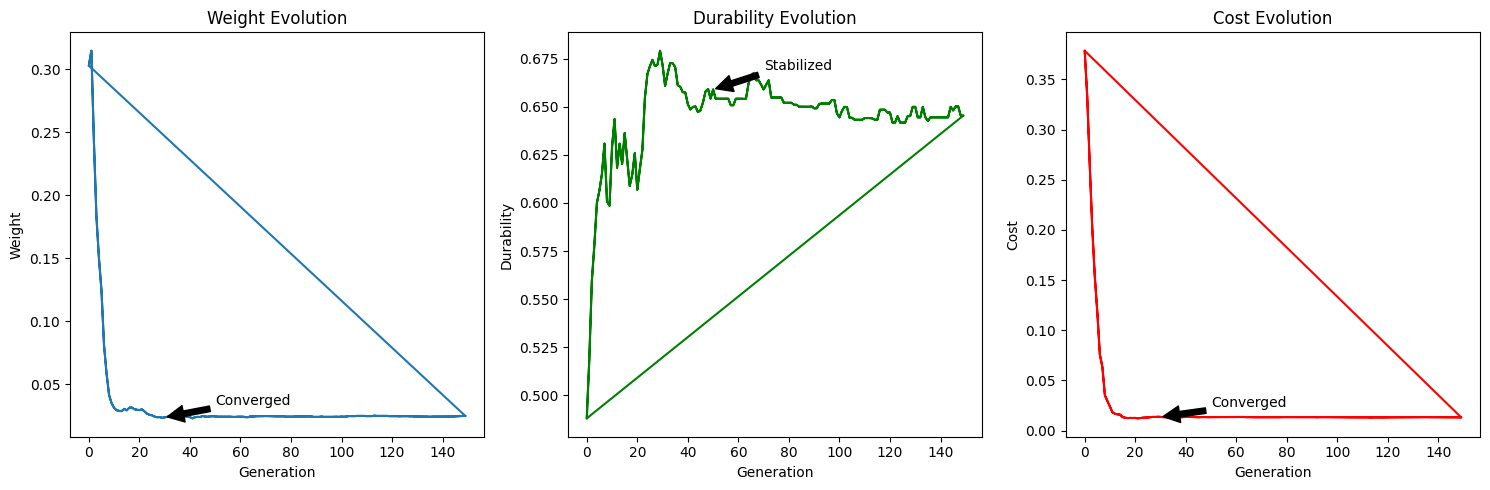

In [22]:
# Annotate Fitness Evolution Plots
def annotate_fitness_evolution(fitness_history):
    plt.figure(figsize=(15, 5))

    # Weight Evolution
    plt.subplot(131)
    plt.plot(fitness_history['generation'], fitness_history['weight'], label='Weight')
    plt.title('Weight Evolution')
    plt.xlabel('Generation')
    plt.ylabel('Weight')
    plt.annotate('Converged', xy=(30, fitness_history['weight'][30]),
                 xytext=(50, fitness_history['weight'][30] + 0.01),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    # Durability Evolution
    plt.subplot(132)
    plt.plot(fitness_history['generation'], fitness_history['durability'], label='Durability', color='g')
    plt.title('Durability Evolution')
    plt.xlabel('Generation')
    plt.ylabel('Durability')
    plt.annotate('Stabilized', xy=(50, fitness_history['durability'][50]),
                 xytext=(70, fitness_history['durability'][50] + 0.01),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    # Cost Evolution
    plt.subplot(133)
    plt.plot(fitness_history['generation'], fitness_history['cost'], label='Cost', color='r')
    plt.title('Cost Evolution')
    plt.xlabel('Generation')
    plt.ylabel('Cost')
    plt.annotate('Converged', xy=(30, fitness_history['cost'][30]),
                 xytext=(50, fitness_history['cost'][30] + 0.01),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.tight_layout()
    plt.show()

# Call the function to annotate fitness evolution
annotate_fitness_evolution(fitness_history)

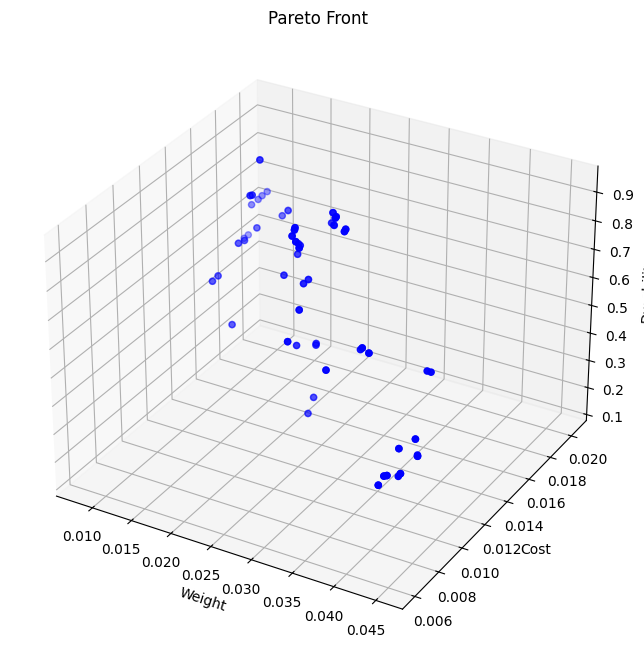

In [23]:
def plot_pareto_front(result):
    pareto_front = result.F
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pareto_front[:, 0], pareto_front[:, 1], -pareto_front[:, 2], color='blue')
    ax.set_xlabel('Weight')
    ax.set_ylabel('Cost')
    ax.set_zlabel('Durability')
    plt.title('Pareto Front')
    plt.show()

plot_pareto_front(result)

In [24]:
def remove_duplicates(solutions, tol=1e-4):
    unique_solutions = []
    for sol in solutions:
        if not any(np.allclose(sol, unique_sol, atol=tol) for unique_sol in unique_solutions):
            unique_solutions.append(sol)
    return np.array(unique_solutions)

# Deduplicate Pareto solutions
filtered_solutions = remove_duplicates(result.X, tol=1e-4)

In [ ]:
weight_min, weight_max = scaler.data_min_[numerical_cols.index('Weight')], scaler.data_max_[numerical_cols.index('Weight')]
durability_min, durability_max = scaler.data_min_[numerical_cols.index('Durability (d)')], scaler.data_max_[numerical_cols.index('Durability (d)')]
cost_min, cost_max = scaler.data_min_[numerical_cols.index('Cost')], scaler.data_max_[numerical_cols.index('Cost')]

# Initialize a list to store formatted results
results = []

for i, solution in enumerate(filtered_solutions):
    material_idx, thickness = int(solution[0]), solution[1]
    material_name = ga_df_scaled.iloc[material_idx]['Material']  # Get material name
    
    # Prepare the input features for prediction
    input_features = pd.DataFrame({
        'Material_encoded': [ga_df_scaled.iloc[material_idx]['Material_encoded']],
        'Thermal Conductivity (W/m*K)_scaled': [ga_df_scaled.iloc[material_idx]['Thermal Conductivity (W/m*K)_scaled']],
        'Material Density (kg/m3)_scaled': [ga_df_scaled.iloc[material_idx]['Material Density (kg/m3)_scaled']],
        'Thickness_scaled': [(thickness - 0.01) / (0.1 - 0.01)]  # Scale thickness for input
    })

    # Make predictions
    predicted_weight = weight_model.predict(input_features)[0]
    predicted_durability = durability_model.predict(input_features)[0]
    predicted_cost = cost_model.predict(input_features)[0]

    # Reverse scaling for outputs
    predicted_weight_original = predicted_weight * (weight_max - weight_min) + weight_min
    predicted_durability_original = predicted_durability * (durability_max - durability_min) + durability_min
    predicted_cost_original = predicted_cost * (cost_max - cost_min) + cost_min

    # Store the results in the required format
    results.append({
        'Material Name': material_name,
        'Thickness (m)': round(thickness, 6),  # Thickness in meters
        'Weight (kg)': round(predicted_weight_original, 6),  # Weight in kilograms
        'Durability (d)': round(predicted_durability_original, 6),  # Durability in days
        'Cost ($)': round(predicted_cost_original, 6)  # Cost in dollars
    })

# Convert the results into a DataFrame for easier viewing and exporting
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv('pareto_optimal_solutions.csv', index=False)


In [26]:
# Display the results
results_df

,Material Name,Thickness (m),Weight (kg),Durability (d),Cost ($)
0,aluminum fluosilicate (topaz) (2 AlFS.SiO2) (a...,0.010001,3.534653e+02,13.592503,3.922933
1,lithium hydride (lih) (cast gas voids),0.010042,2.565195e+04,47.312890,463.683653
2,steel stainless (Cr 12-13 Ni 0-3),0.010001,7.755060e+02,45.395523,5.095864
3,iron ductile,0.010007,1.164948e+04,42.338013,67.094277
4,yttrium,0.010342,6.470453e+05,93.174980,3923.501482
5,sodium (liquid),0.010038,2.338263e+04,59.201813,437.609561
6,boron nitride (Bn 80 C 20) (prs axis),0.010000,1.709579e+01,34.664366,0.185106
7,aluminum fluosilicate (topaz) (2 AlFO.SiO2) (c...,0.010000,3.521091e+01,18.324091,0.304791
8,zinc sulfide (ZnS) (cubic crystal),0.010113,2.461420e+05,90.376715,1164.848821
9,boron carbide (B4C) (porous),0.010000,6.553075e+01,77.405804,0.662783
